In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Preprocessing

In [37]:
df_movies=pd.read_csv('./ml-latest-small/ml-latest-small/movies.csv')

In [38]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [39]:
df_ratings=pd.read_csv('./ml-latest-small/ml-latest-small/ratings.csv')


In [40]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [41]:
transactional_dataset = df_ratings[df_ratings['rating']>2]

In [42]:
data_set={}
for userid in transactional_dataset['userId'].unique():
    if userid not in data_set:
        data_set[userid]=set()
    temp_df=transactional_dataset[transactional_dataset['userId']==userid]
    for i in range(len(temp_df)):
        data_set[userid].add(temp_df.iloc[i]['movieId'])
    if len(data_set[userid])<=10:
        del data_set[userid]

In [43]:
import random
training_set={}
testing_set={}
for key in data_set.keys():
    lst=list(data_set[key])
    n=len(lst)
    train_len=int(n*0.8)
    test_len=n-train_len
    random.shuffle(lst)
    if key not in training_set:
        training_set[key]=set()
        train_lst=set(lst[:train_len])
        training_set[key]=train_lst
    if key not in testing_set:
        testing_set[key]=set()
        test_lst=set(lst[train_len:])
        testing_set[key]=test_lst


### Association Rule Mining

In [56]:
dummy={1:{1,2,5},2:{2,4},3:{2,3},4:{1,2,4},5:{1,3},6:{2,3},7:{1,3},8:{1,2,3,5},9:{1,2,3}}

In [67]:
dummy=training_set
min_sup=50
min_conf=0.1

In [68]:
L={}
for key in dummy.keys():
    se=dummy[key]
    for val in se:
        if val not in L:
            L[val]=1
        else:
            L[val]+=1
print(L)


{1024.0: 5, 1025.0: 16, 1.0: 171, 3.0: 34, 1029.0: 22, 6.0: 76, 1031.0: 18, 1032.0: 31, 2054.0: 35, 2058.0: 17, 1030.0: 8, 527.0: 159, 1042.0: 33, 2580.0: 34, 1049.0: 17, 3617.0: 25, 2596.0: 8, 1060.0: 24, 1573.0: 57, 553.0: 47, 2090.0: 11, 2093.0: 5, 2094.0: 26, 47.0: 144, 2096.0: 17, 1073.0: 91, 50.0: 169, 2099.0: 3, 3639.0: 12, 2616.0: 15, 1080.0: 58, 2105.0: 36, 1090.0: 51, 2115.0: 79, 2116.0: 8, 2628.0: 81, 70.0: 37, 1097.0: 85, 3147.0: 89, 590.0: 131, 2640.0: 48, 593.0: 231, 2641.0: 31, 2644.0: 7, 596.0: 40, 1620.0: 8, 3671.0: 48, 2648.0: 9, 1625.0: 54, 2139.0: 15, 2141.0: 9, 2654.0: 3, 2143.0: 8, 608.0: 139, 3168.0: 24, 101.0: 16, 1127.0: 44, 1644.0: 12, 1136.0: 109, 2161.0: 32, 3702.0: 29, 3703.0: 32, 2174.0: 60, 2692.0: 57, 1676.0: 41, 2700.0: 58, 2193.0: 29, 3729.0: 3, 661.0: 35, 151.0: 35, 2716.0: 85, 157.0: 5, 3744.0: 8, 673.0: 29, 163.0: 45, 3243.0: 7, 1196.0: 150, 1197.0: 115, 1198.0: 157, 3247.0: 21, 3253.0: 46, 1206.0: 95, 1208.0: 85, 1213.0: 97, 1214.0: 107, 1732.0: 72

In [69]:
#now we need to sort the dictionary in descending order
L = dict(sorted(L.items(),key=lambda item: item[1],reverse=True))
print(L)

{318.0: 254, 356.0: 245, 296.0: 232, 593.0: 231, 2571.0: 208, 480.0: 189, 260.0: 186, 110.0: 172, 1.0: 171, 50.0: 169, 2959.0: 169, 589.0: 162, 527.0: 159, 1198.0: 157, 2858.0: 152, 4993.0: 152, 1196.0: 150, 1210.0: 149, 5952.0: 147, 47.0: 144, 588.0: 144, 32.0: 143, 150.0: 143, 2028.0: 142, 7153.0: 141, 592.0: 140, 608.0: 139, 457.0: 139, 780.0: 137, 858.0: 134, 2762.0: 132, 590.0: 131, 364.0: 130, 380.0: 128, 4306.0: 128, 3578.0: 127, 1270.0: 126, 6539.0: 122, 4226.0: 122, 1580.0: 121, 377.0: 119, 58559.0: 119, 1704.0: 116, 1197.0: 115, 648.0: 115, 1265.0: 111, 1291.0: 110, 1136.0: 109, 79132.0: 109, 1036.0: 108, 1214.0: 107, 595.0: 107, 1193.0: 106, 6377.0: 105, 6874.0: 105, 367.0: 104, 1240.0: 103, 165.0: 103, 293.0: 103, 2329.0: 103, 500.0: 102, 1089.0: 102, 1221.0: 101, 4995.0: 100, 7361.0: 100, 597.0: 99, 4886.0: 99, 1213.0: 97, 10.0: 96, 1206.0: 95, 316.0: 95, 1682.0: 95, 34.0: 94, 1721.0: 94, 1527.0: 94, 4973.0: 94, 3793.0: 93, 4963.0: 93, 1073.0: 91, 5349.0: 91, 1200.0: 90, 5

In [70]:
class TreeNode:
    def __init__(self,id=-1,cnt=0):
        self.id=id
        self.cnt=cnt
        self.pointers={} #stores key id and value is reference to a node 

    def check(self,node):
        if node not in self.pointers:
            return False
        return True
    def get(self,node):
        return self.pointers[node]
    

In [71]:
class Tree:
    def __init__(self):
        self.root=TreeNode()
        self.par={} # node to node
        self.dic={}
    def insert(self,lst,inc=1):
        temp=self.root
        prev=None
        for x in lst:
            if temp.check(x)==False:
                temp.pointers[x]=TreeNode(x,0)
            self.par[temp]=prev
            prev=temp
            temp=temp.get(x)
            if temp.id not in self.dic:
                self.dic[temp.id]=set()
            self.dic[temp.id].add(temp)
            temp.cnt+=inc
    def show(self,root):
        for key in root.pointers.keys():
            temp=root.pointers[key]
            st="id "+str(temp.id)+" "+"cnt "+str(temp.cnt)
            print(st)
            self.show(temp)

    def helper_path(self,node,path,item,ans):
        if node.id==item:
            ans[tuple(path)]=node.cnt
            return
        for key,value in node.pointers.items():
            path.append(key)
            self.helper_path(value,path,item,ans)
            path.pop()

    def get_paths(self,item):
        #gets paths to that node
        ans={} # key is set and value is cnt
        temp=self.root
        path=[]
        for key in temp.pointers.keys():
            path.append(key)
            self.helper_path(temp.pointers[key],path,item,ans)
            path.pop()
        return ans
            
    def print_par(self):
        for key,val in self.par.items():
            if key is not None and val is not None:
                print(key.id,val.id)
    

In [72]:
#create a root node
tree=Tree()
#now iterate through the transactions (ie dummy) and insert the items in the order of L
order_of_insertion=list(L.keys())
#print(order_of_insertion)
for key,values in dummy.items():
    # insert the values in the values in the order of L
    lst=list(values)
    ordered_lst=sorted(lst,key=lambda x: order_of_insertion.index(x))
    #print(ordered_lst)
    tree.insert(ordered_lst)

#tree.show(tree.root)

In [73]:
rules=[] # (string, support, confidence)

In [74]:
# now creating conditional pattern base
# so for every path ending with item push the path into a list
def build_L(conditional_pattern_base):
    L_conditional={}
    def fill_L(itemset,sup_count):
        for item in itemset:
            if item not in L_conditional:
                L_conditional[item]=sup_count
            else:
                L_conditional[item]+=sup_count

    for itemset,sup_count in conditional_pattern_base.items():
        lst=list(itemset)
        lst.pop()
        fill_L(lst,sup_count)
    keys_to_delete=[]
    for key, cnt in L_conditional.items():
        if cnt<min_sup:
            keys_to_delete.append(key)
    for key in keys_to_delete:
        if key in L_conditional:
            del L_conditional[key]
    return L_conditional

def generate_rules(path,sup_count):
    for elem in path:
        #generate total-elem set 
        rem = tuple([x for x in path if x!=elem])
        rem_str=','.join(map(str,rem))
        rule=str(elem)+"-> {"+rem_str+"}"
        confidence=sup_count/L[elem]
        if confidence>=min_conf:
            tup=(rule,sup_count,confidence)
            rules.append(tup)


temp_lst=list(L.keys())
for item in reversed(temp_lst):
    #for the item 
    conditional_pattern_base=tree.get_paths(item)
    L_conditional=build_L(conditional_pattern_base)
    #now sort the L in descending order
    L_conditional = dict(sorted(L_conditional.items(),key=lambda item: item[1],reverse=True))
    order_of_insertion=list(L_conditional.keys())
    tree_conditional=Tree()
    merged_set=set()
    for itemset,sup_count in conditional_pattern_base.items():
        lst=list(itemset)
        lst.pop()
        # for x in lst:
        #     if x not in order_of_insertion:
        #         lst.remove(x)
        lst = [x for x in lst if x in order_of_insertion]
        ordered_lst=sorted(lst,key=lambda x: order_of_insertion.index(x))
        set1=set(lst)
        merged_set=merged_set | set1
        tree_conditional.insert(ordered_lst,sup_count)
    #print(L_conditional)
    # print("for item ",item)
    # tree_conditional.show(tree_conditional.root)

    #after building the tree we need to extract frequent patterns
    #print("for item ",item)
    for elem in merged_set:
        #print("for elem ",elem)
        ds=tree_conditional.get_paths(elem) # key is path and val cnt
        #print(ds)
        for path,sup_count in ds.items():
            path_=list(path)
            path_.append(item)
            #now for every path generate rules
            generate_rules(path_,sup_count)


{(2571.0,): 51}
{(356.0,): 53}
{(6539.0,): 51}
{(6539.0, 5349.0): 39, (5349.0,): 11}
{(4306.0,): 51}
{(58559.0,): 53}
{(356.0,): 51}
{(457.0,): 50}
{(2571.0,): 51}
{(6539.0, 7153.0): 37, (7153.0,): 13}
{(6539.0,): 51}
{(2959.0, 4993.0): 35, (4993.0,): 15}
{(2959.0,): 52}
{(457.0, 480.0): 37, (480.0,): 14}
{(457.0, 480.0, 356.0): 28, (457.0, 356.0): 10, (480.0, 356.0): 12, (356.0,): 1}
{(457.0,): 53}
{(480.0,): 12, (356.0, 480.0): 40}
{(356.0,): 56}
{(356.0,): 55}
{(593.0,): 56}
{(2571.0,): 51}
{(2571.0, 2959.0): 37, (2959.0,): 14}
{(608.0,): 50}
{(1.0,): 54}
{(593.0,): 54}
{(593.0, 296.0, 50.0): 28, (593.0, 50.0): 10, (296.0, 50.0): 9, (50.0,): 5}
{(593.0, 296.0, 50.0, 2858.0, 356.0): 16, (593.0, 296.0, 50.0, 356.0): 5, (593.0, 296.0, 2858.0, 356.0): 3, (593.0, 296.0, 356.0): 3, (593.0, 50.0, 356.0): 2, (593.0, 50.0, 2858.0, 356.0): 6, (593.0, 2858.0, 356.0): 3, (593.0, 356.0): 2, (296.0, 50.0, 2858.0, 356.0): 3, (296.0, 50.0, 356.0): 2, (296.0, 2858.0, 356.0): 3, (296.0, 356.0): 1, (5

In [83]:
rules[0]

('2571.0-> {6365.0}', 51, 0.24519230769230768)

In [82]:
df_movies.head()
#map movie id to title
dic_movie_={}
for i in range(len(df_movies)):
    dic_movie_[int(df_movies.iloc[i]['movieId'])]=df_movies.iloc[i]['title']

In [112]:
def write_to_file(list_of_tuples,file_name):
    lst=["Rule , Support , Confidence \n"]

    for tuple in list_of_tuples:
        rule=tuple[0]
        support=tuple[1]
        confidence=tuple[2]
        lst_rules=rule.split('->')
        A=lst_rules[0]
        B=lst_rules[1][2:-1]
        B_lst=B.split(',')
        recommmended_movies=[dic_movie_[int(float(id))] for id in B_lst]
        reco_str=','.join(recommmended_movies)
        st=dic_movie_[int(float(A))]+"-> {"+reco_str+"} , "+str(support)+" , "+str(confidence)+" \n"
        lst.append(st)
    with open(file_name,'w') as f:
        f.writelines(lst)


In [113]:
top_support_rules=sorted(rules,key=lambda x: x[1],reverse=True)[:100]
top_confidence_rules=sorted(rules,key=lambda x: x[2],reverse=True)[:100]
shared_rules=[t1 for t1 in top_support_rules for t2 in top_confidence_rules if t1==t2]
shared_rules=sorted(shared_rules,key=lambda x: x[2],reverse=True)

In [114]:
write_to_file(top_support_rules,'10_top100RulesBySup.txt')
write_to_file(top_confidence_rules,'10_top100RulesByConf.txt')

In [116]:
write_to_file(shared_rules,'shared_rules.txt')

In [121]:
shared_rules

[('5952.0-> {4993.0}', 113, 0.7687074829931972),
 ('597.0-> {356.0}', 74, 0.7474747474747475),
 ('7153.0-> {4993.0}', 105, 0.7446808510638298),
 ('4993.0-> {5952.0}', 113, 0.743421052631579),
 ('1221.0-> {858.0}', 75, 0.7425742574257426),
 ('500.0-> {356.0}', 75, 0.7352941176470589),
 ('595.0-> {588.0}', 78, 0.7289719626168224),
 ('47.0-> {296.0}', 102, 0.7083333333333334),
 ('1196.0-> {260.0}', 105, 0.7),
 ('1291.0-> {1198.0}', 77, 0.7),
 ('4993.0-> {7153.0}', 105, 0.6907894736842105),
 ('527.0-> {318.0}', 109, 0.6855345911949685),
 ('2762.0-> {2571.0}', 90, 0.6818181818181818),
 ('377.0-> {356.0}', 81, 0.680672268907563),
 ('1210.0-> {260.0}', 99, 0.6644295302013423),
 ('2028.0-> {2571.0}', 94, 0.6619718309859155),
 ('364.0-> {356.0}', 86, 0.6615384615384615),
 ('3578.0-> {2571.0}', 84, 0.6614173228346457),
 ('480.0-> {356.0}', 124, 0.656084656084656),
 ('6539.0-> {356.0}', 80, 0.6557377049180327),
 ('589.0-> {480.0}', 106, 0.654320987654321),
 ('590.0-> {593.0}', 85, 0.6488549618320

In [124]:
len(training_set[1]) #contains movieIds rated by that user

180

In [129]:
type(training_set[1])

set

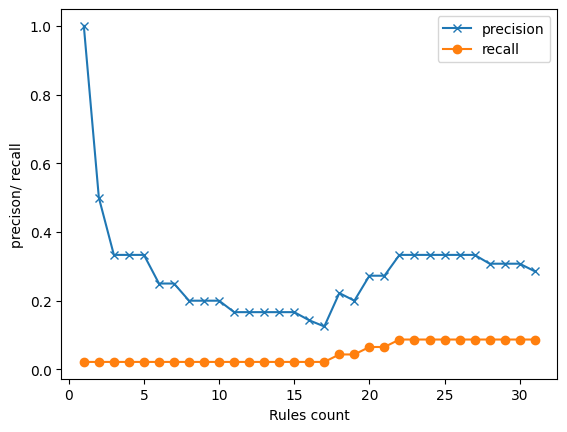

In [136]:
import matplotlib.pyplot as plt
def plot_precision_and_recall(user):
    #first put all the rules of this user in a list
    train_movies=training_set[user]
    test_movies=testing_set[user]
    lst=[]
    #for each movie in train_movies check if it's in shared rules
    def get_rules(movie):
        #iterate the shared rules
        temp=[]
        for tup in sorted(rules,key=lambda x: x[2],reverse=True)[:1000]:
            rule=tup[0]
            X=rule.split('->')
            if int(float(X[0]))==int(float(movie)):
                temp.append(tup)
        return temp
    
    def get_Y(rule):
        te=rule.split('->')[1]
        st=te[2:-1]
        Y_lst=st.split(',')
        Y_lst=[int(float(x)) for x in Y_lst]
        return Y_lst

    for movie in train_movies:
        lst_rules=get_rules(movie)
        for r in lst_rules:
            lst.append(r)
        if len(lst)>=30:
            break


    temp_rules=[]
    R=set()
    X_axis=[]
    precison_lst=[]
    recall_lst=[]
    counter=1
    for tup in lst:
        temp_rules.append(tup[0])
        y_temp=get_Y(tup[0])
        for y in y_temp:
            R.add(y)
        hit=R & test_movies
        recall=len(hit)/len(test_movies)
        precision=len(hit)/len(R)
        X_axis.append(counter)
        counter+=1
        precison_lst.append(precision)
        recall_lst.append(recall)

    plt.plot(X_axis,precison_lst,label='precision',marker='x')
    plt.plot(X_axis,recall_lst,label='recall',marker='o')
    plt.xlabel('Rules count')
    plt.ylabel('precison/ recall')
    plt.legend()
    plt.show()

plot_precision_and_recall(1)
    

    

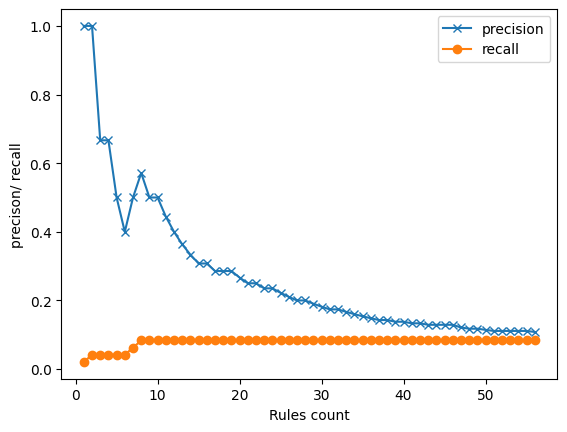

In [137]:
plot_precision_and_recall(50)

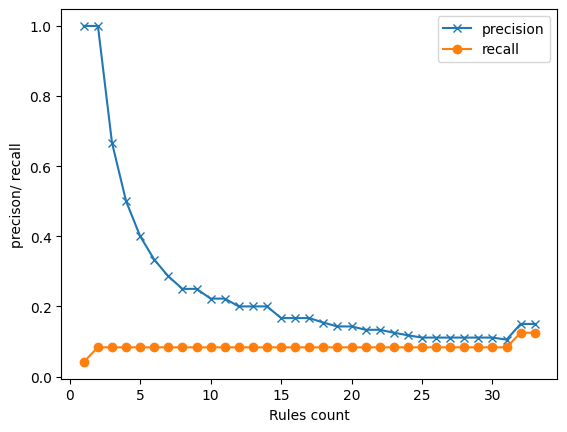

In [138]:
plot_precision_and_recall(10)